In [1]:
#Import Dependencies
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import geopandas as gpd
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import shapiro, normaltest
from statsmodels.graphics.gofplots import qqplot
from pingouin import multivariate_normality
import pingouin
from bioinfokit.analys import stat as bs
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the data from the Excel file
file_path = r"E:\GitHub\sherlock-final-project\x_prediction_3.xlsx"
data = pd.read_excel(file_path)
data_y = pd.read_excel("E:\GitHub\sherlock-final-project\y_prediction.xlsx")

# Select the data from the 103rd to the 136th row (103-based indexing)
datadf = data.iloc[102:136]
data = np.array(datadf)
data_y = data_y.iloc[68:102]
data_y = np.array(data_y.iloc[:,1])

In [3]:
X = np.column_stack([data[:,1],data[:,2],data[:,3]])

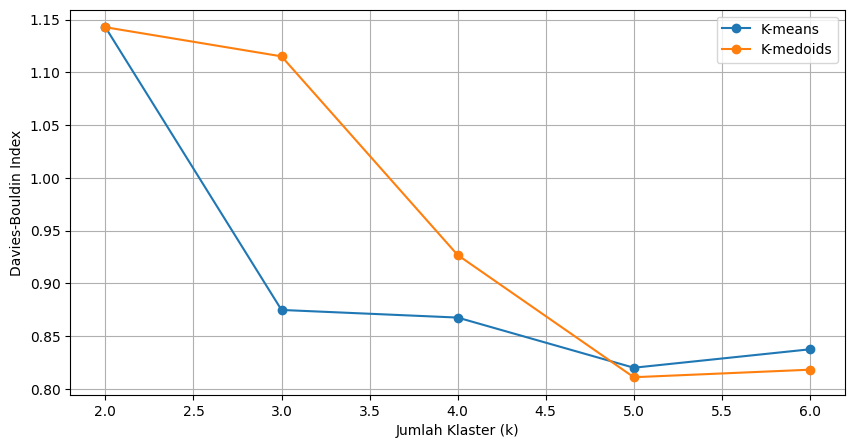

In [12]:
# Inisiasi List untuk menyimpan data
kmeans_scores = []
kmedoids_scores = []
kmeans_initcen_list = []
kmeans_fincen_list = []
kmedoids_initmed_list = []
kmedoids_finmed_list = []
b_kmeans = None
b_kmedoids = None
b_kmeans_score = float('inf')
b_kmedoids_score = float('inf')
b_kmeans_initcen = None
b_kmeans_fincen = None
b_kmedoids_initmed = None
b_kmedoids_finmed = None

# Fungsi untuk menginisiasi centroid/medoid awal secara random
def initialize_centroids(X, k, seed=None):
    if seed is not None:
        np.random.seed(seed)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

# Iterasi K-means dan K-medoids untuk 2-6 klaster
for n_clusters in range(2, 7):
    initcen = initialize_centroids(X, n_clusters, seed=0)
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, init=initcen, n_init=1, random_state=0)
    kmeans.fit(X)
    kmeans_initcen = initcen  # Menyimpan centroid awal
    kmeans_fincen = kmeans.cluster_centers_
    kmeans_labels = kmeans.labels_
    # Menyimpan centroid awal dan akhir ke dalam list
    kmeans_initcen_list.append(kmeans_initcen)
    kmeans_fincen_list.append(kmeans_fincen)
    # Perhitungan DBI
    try:
        kmeans_db_score = davies_bouldin_score(X, kmeans_labels)
    except:
        kmeans_db_score = float('inf')
    kmeans_scores.append(kmeans_db_score)
    if kmeans_db_score < b_kmeans_score:
        b_kmeans_score = kmeans_db_score
        b_kmeans = (n_clusters, kmeans, kmeans_labels)
        b_kmeans_labels = kmeans_labels
        b_kmeans_initcen = kmeans_initcen
        b_kmeans_fincen = kmeans_fincen
    # K-medoids clustering
    kmedoids = KMedoids(n_clusters=n_clusters, init=initcen, random_state=0)
    kmedoids.fit(X)
    kmedoids_initmed = initcen  # Menyimpan medoid awal
    kmedoids_finmed = kmedoids.cluster_centers_
    kmedoids_labels = kmedoids.labels_
    # Menyimpan medoid awal dan akhir ke dalam list
    kmedoids_initmed_list.append(kmedoids_initmed)
    kmedoids_finmed_list.append(kmedoids_finmed)
    # Perhitungan DBI
    try:
        kmedoids_db_score = davies_bouldin_score(X, kmedoids_labels)
    except:
        kmedoids_db_score = float('inf')
    kmedoids_scores.append(kmedoids_db_score)
    if kmedoids_db_score < b_kmedoids_score:
        b_kmedoids_score = kmedoids_db_score
        b_kmedoids = (n_clusters, kmedoids, kmedoids_labels)
        b_kmedoids_labels = kmedoids_labels
        b_kmedoids_initmed = kmedoids_initmed
        b_kmedoids_finmed = kmedoids_finmed

# Plot DBI untuk K-means dan K-medoids
plt.figure(figsize=(10, 5))
plt.plot(range(2, 7), kmeans_scores, label='K-means', marker='o')
plt.plot(range(2, 7), kmedoids_scores, label='K-medoids', marker='o')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Menyimpan data K-means dan K-medoids terbaik
cluster_summary = datadf
cluster_summary['y'] = data_y
cluster_summary['kmeans'] = b_kmeans_labels
cluster_summary['kmedoids'] = b_kmedoids_labels 
#cluster_summary.to_excel('cluster_summary.xlsx')

In [8]:
kmeansinit = pd.DataFrame(b_kmedoids_initmed)
kmeansinit.to_excel('kmedoidsinit.xlsx')